In [1]:
!nvidia-smi #show GPU

Thu Dec 31 14:40:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Import essential libraries
import numpy as np
from tensorflow import keras
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow as tf


In [3]:
# Define sampling layer for getting a value from the input pixel mean and standard variation
class Sampling(layers.Layer):
   def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
# Define Model1
def VAE_model1():
  latent_dim = 2 #Mean and mu
  #defining encoder
  encoder_inputs = keras.Input(shape=(28, 28, 1)) #inout image
  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(16, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x) #dense layer for getting the mean value
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x) #dense layer for gettinh th mu value
  z = Sampling()([z_mean, z_log_var]) #get the sampled value from the mean and mu
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()
  #defining decoder
  latent_inputs = keras.Input(shape=(latent_dim,)) #input is the latent space
  x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs) 
  x = layers.Reshape((7, 7, 64))(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x) #last layer must be equal to the deaful size of images (28*28)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  decoder.summary()
  return (encoder,decoder)

In [5]:
def VAE_model2():
  latent_dim = 2
  encoder_inputs = keras.Input(shape=(28, 28, 1))
  x = layers.Conv2D(16, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
  x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(16, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()
  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
  x = layers.Reshape((7, 7, 64))(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(16, 3, activation="relu", strides=1, padding="same")(x)
  decoder_outputs = layers.Conv2DTranspose(1, 3, activation="softmax", padding="same")(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  decoder.summary()
  return (encoder,decoder)

In [6]:
def VAE_model3():
  latent_dim = 2
  encoder_inputs = keras.Input(shape=(28, 28, 1))
  x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
  x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(32, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()
  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
  x = layers.Reshape((7, 7, 64))(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
  decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  decoder.summary()
  return (encoder,decoder)

In [7]:
# Create the VAE model using the encoder and decoder and the Kullback–Leibler divergence and
#binary crossentropy losses
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [8]:
def plot_generated_images(encoder, decoder,model_num):
  # display a n*n 2D manifold of digits
  n = 30 #number of the selected points of samples
  digit_size = 28
  scale = 2.0 
  figsize = 15
  figure = np.zeros((digit_size * n, digit_size * n))
  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-scale, scale, n) #how the random mean values are selected
  grid_y = np.linspace(-scale, scale, n)[::-1] #how the random mu values are selected

  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]]) #a random sample
          x_decoded = decoder.predict(z_sample) #generated image
          digit = x_decoded[0].reshape(digit_size, digit_size) #resize to 28*28
          figure[
              i * digit_size : (i + 1) * digit_size,
              j * digit_size : (j + 1) * digit_size,
          ] = digit

  plt.figure(figsize=(figsize, figsize))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range + 1
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("Mean")
  plt.ylabel("Standar Variation")
  plt.imshow(figure, cmap="Greys_r")
  plt.savefig('{}-generated_image.pdf'.format(model_num))
  plt.show()


In [9]:
def plot_latent(encoder, decoder, data, labels,model_num):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("Mean")
    plt.ylabel("Standar Variation")
    plt.savefig('{}-latenspace.pdf'.format(model_num))
    plt.show()



Running model 1
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________

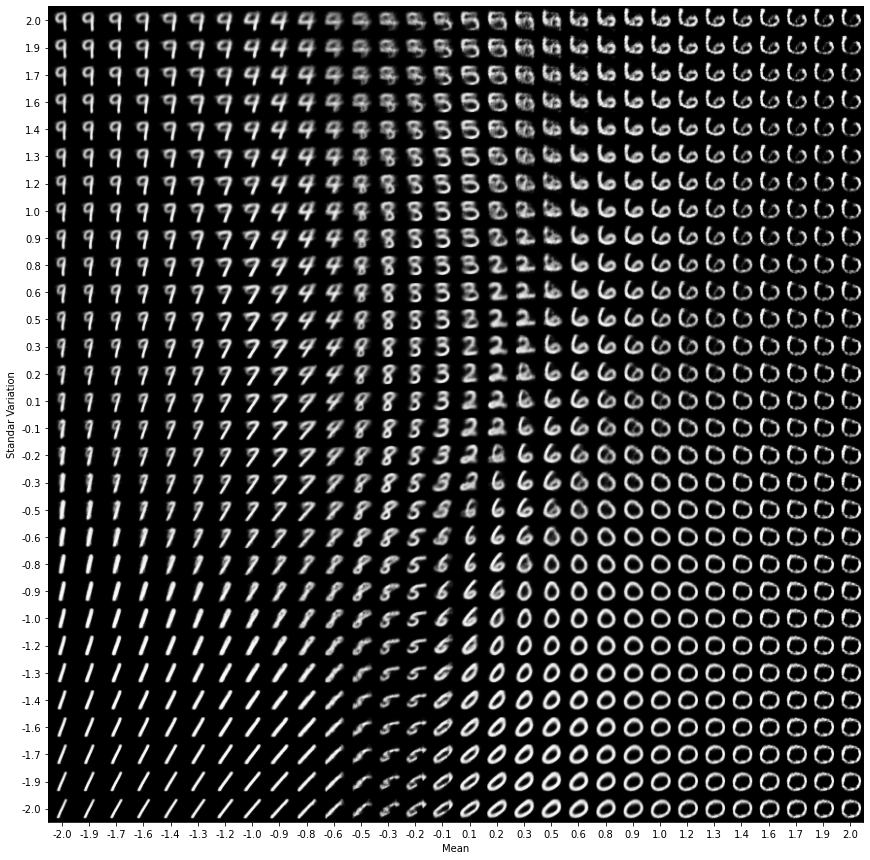

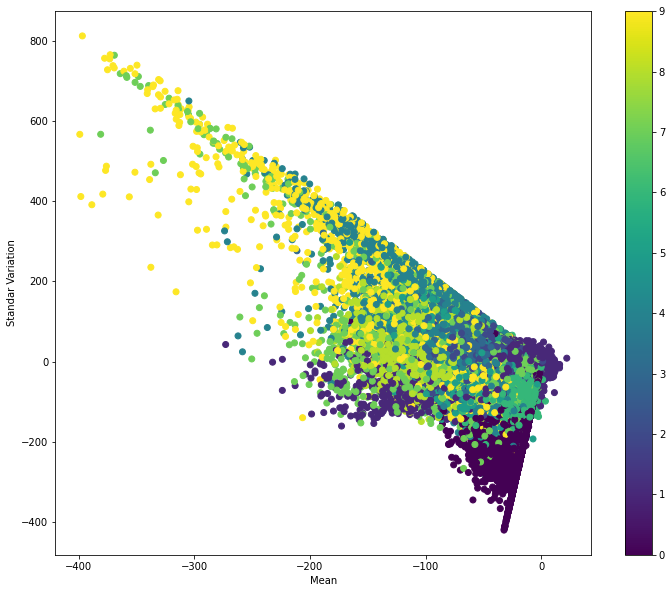

Running model 2
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 32)   4640        conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 64)   18496       conv2d_3[0][0]                   
____________________________________________________________________________

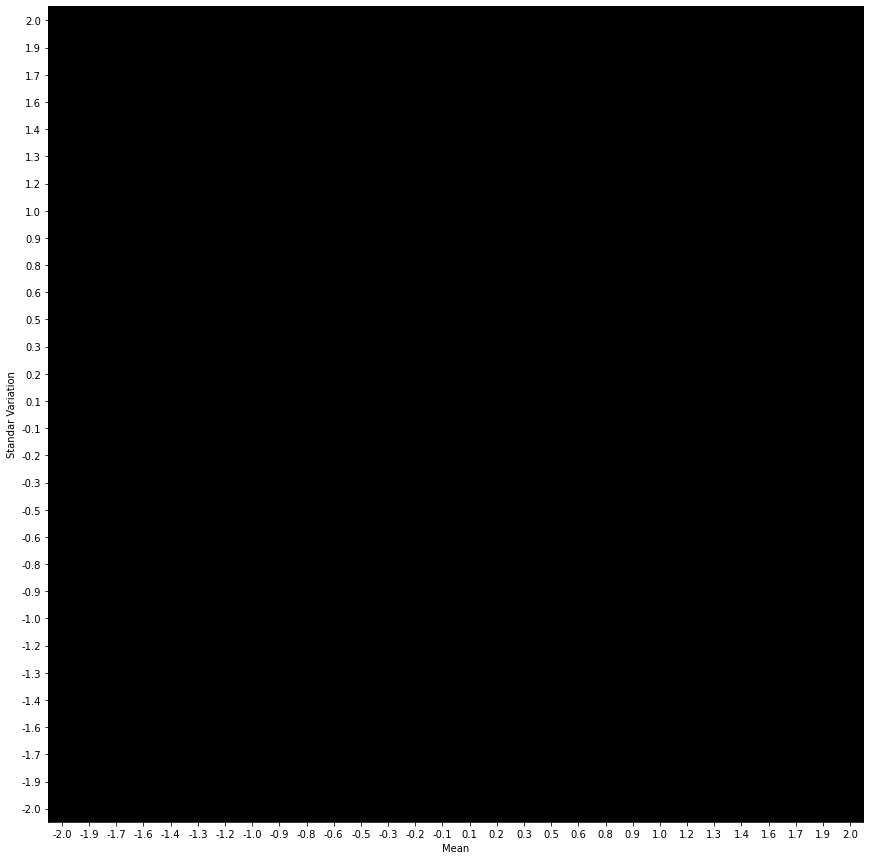

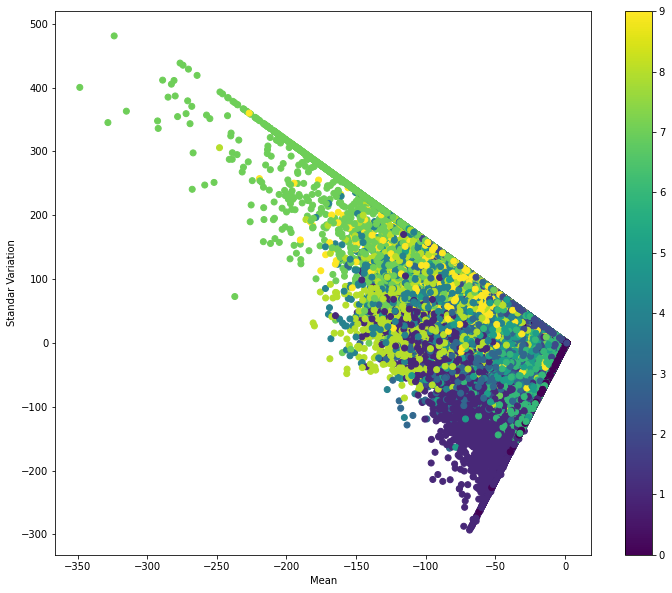

Running model 3
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 64)   18496       conv2d_6[0][0]                   
____________________________________________________________________________

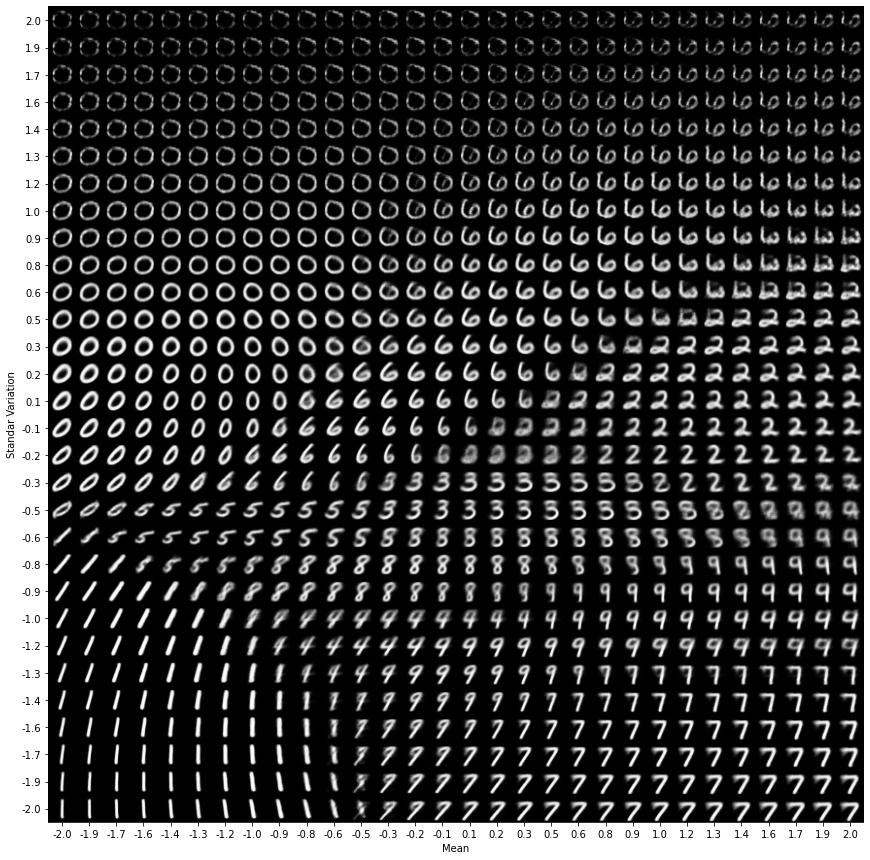

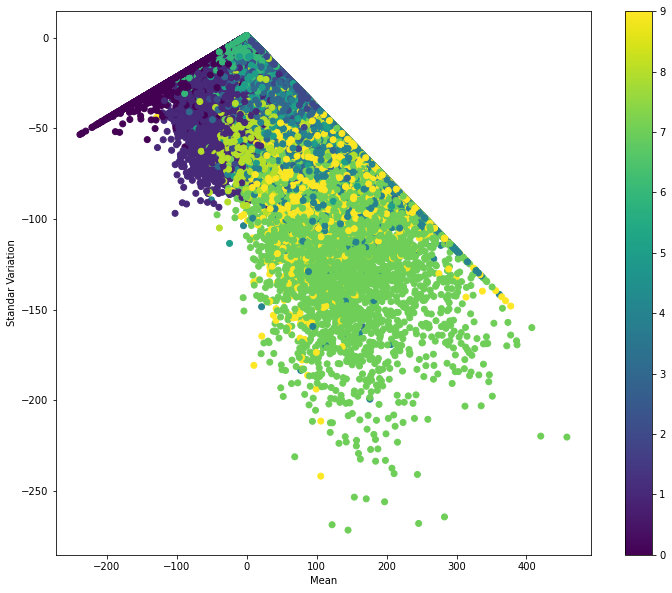

In [10]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #Get MNIST Dataset
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255 #Preprocess

for i in range(1,4): #Number of model
  print('Running model {}'.format(i))
  encoder, decoder =globals()['VAE_model{}'.format(i)]() #Create encoder and decoder
  vae = VAE(encoder, decoder) #Create VAE model
  vae.compile(optimizer=keras.optimizers.Adam())
  vae.fit(mnist_digits, epochs=50, batch_size=128) #start training
  plot_generated_images(encoder, decoder,model_num=i) #Plot generated images
  plot_latent(encoder, decoder, x_train, y_train,model_num=i) #Plot latent space

In [32]:
figure.shape

(280, 56)

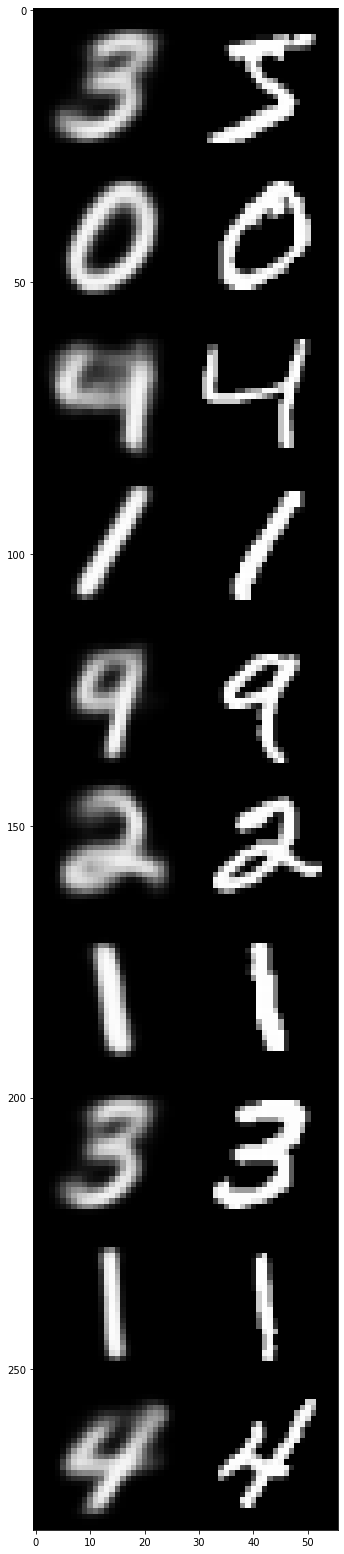

In [58]:
#Compairing the generated images with the real images
figure = np.zeros((28 * 10, 56 ))
for i in range(10):
  img=x_train[i]
  img=np.expand_dims(img, 0)
  img=np.expand_dims(img, -1).astype("float32") / 255
  re=encoder.predict(img)
  pred=decoder.predict(re[2])
  figure[i * 28 : (i + 1) * 28, 0:28,] = (pred[0,:,:,0]*255).astype(np.uint8)
  figure[i * 28 : (i + 1) * 28, 28:56,] = x_train[i]

plt.figure(figsize=(28, 28))
plt.imshow(figure, cmap="Greys_r")
#print('############')
plt.savefig('compare.jpg')
plt.savefig('compare.pdf')